# Отток клиентов

Из «Банка» стали уходить клиенты. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импорт необходимых библиотек

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df['Tenure'].isna().sum()

909

Обнаружили в признаке Tenure (сколько лет человек является клиентом банка) 909 пропусков

In [5]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

Заполним пропуски средним значением

Проводим OHE (One-Hot Encoding) для работы логистической регрессии она работает только с численными значениями

In [6]:
df = df.drop(['CustomerId', 'Surname', 'RowNumber'] , axis=1)

In [7]:
data_ohe = pd.get_dummies(df, drop_first=True)

In [8]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Разделим выборку на признаки и целевой признак <br>
Выделим тестовую выборку

In [9]:
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'] , axis=1)
n = df.shape[0]
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=17)

Выделим валидационную выборку

In [10]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=17)

In [11]:
print(f'Размер обучающего набора: {features_train.shape[0]/n}\
        размер проверочного набора: {features_valid.shape[0]/n}\
        размер тестового набора: {features_test.shape[0]/n}'\
     )

Размер обучающего набора: 0.6        размер проверочного набора: 0.2        размер тестового набора: 0.2


In [12]:
print(f'Среднее обучающего набора: {target_train.mean()}\
        среднее проверочного набора: {target_valid.mean()}\
        среднее тестового набора: {target_test.mean()}'\
     )

Среднее обучающего набора: 0.203        среднее проверочного набора: 0.2025        среднее тестового набора: 0.207


Отмасштабируем числовые признаки, чтобы алгоритм не решил, что больший по размерности признак более важен

In [13]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

In [14]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Исследование задачи

Решаем задачу бинарной классификации

### Логистическая регрессия

In [15]:
model = LogisticRegression(solver='liblinear')
model.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(f1_score(target_valid, predicted_valid))
print(roc_auc_score(target_valid, probabilities_one_valid))

0.3563636363636363
0.7649924532683153


F1 - гармоническое среднее полноты и точности, крайне низкое значение на валидации <br>
AUC ROC - близко к случайному алгоритму

### Решающее дерево

In [17]:
tree = DecisionTreeClassifier(
    random_state=17,
    max_depth=5
)

Для подбора гиперпараметров используем GridSearch CV с кроссвалидацией.
Подбираем максимальную глубину дерева

In [18]:
tree_params = {'max_depth': list(range(1,100))}

In [19]:
tree_grid = GridSearchCV(tree,
                         tree_params,
                         cv=5,
                         n_jobs=-1,
                         scoring='f1'
                        )

In [20]:
tree_grid.fit(features_train, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=17,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19

In [21]:
probabilities_valid = tree_grid.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(f1_score(target_valid, tree_grid.predict(features_valid)))
print(roc_auc_score(target_valid, probabilities_one_valid))

0.5434083601286174
0.8225395719648592


F1 - значение на валидации лучше логистической регрессии <br>
AUC ROC - тоже лучше чем у логистической регрессии

### Случайный лес

In [22]:
forest = RandomForestClassifier(
    random_state=17,
    max_depth=10,
    n_estimators=5
)

In [23]:
forest_params = {'max_depth': list(range(1,20)),
                'n_estimators': list(range(1,10))
                }

In [24]:
forest_grid = GridSearchCV(forest,
                           forest_params,
                           cv=5,
                           n_jobs=-1,
                           scoring='f1'
                          )

In [25]:
forest_grid.fit(features_train, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=5, n_jobs=None,
                                              oob_score=False, random_state=17,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth

In [26]:
print(forest_grid.best_params_, forest_grid.best_score_)

{'max_depth': 12, 'n_estimators': 9} 0.5712636342084015


In [27]:
probabilities_valid = forest_grid.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(f1_score(target_valid, forest_grid.predict(features_valid)))
print(roc_auc_score(target_valid, probabilities_one_valid))

0.5524691358024693
0.8333836448778977


F1 - значение на валидации чуть хуже чем у решающего дерева <br>
AUC ROC - значение почти не поменялось

## Борьба с дисбалансом

### Увеличение выборки

In [28]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Напишем и применим функцию увеличивающую признаки у которых целевой признак = 1, чтобы выровнить баланс классов. Перемешаем результат.

In [29]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
   
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled  =shuffle(target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled 

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9654, 11)
(9654,)


#### Логистическая регрессия

In [30]:
model = LogisticRegression(solver='liblinear')
model.fit(features_upsampled, target_upsampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(f1_score(target_valid, predicted_valid))
print(roc_auc_score(target_valid, probabilities_one_valid))

0.4720279720279721
0.7684275707264212


F1 - значение на валидации стало лучше чем до выравнивания баланса классов <br>
AUC ROC - значение почти не поменялось

#### Решающее дерево

In [32]:
def param_tree_search(features_train, target_train, features_valid, target_valid):
    score_dict = {}
    for depth in range(1, 30, 1):
        tree = DecisionTreeClassifier(random_state=17, max_depth=depth)
        tree.fit(features_train, target_train)
        score_dict[depth] = f1_score(target_valid, tree.predict(features_valid))
    for k in sorted(score_dict, key=score_dict.get, reverse=True):
        print(f'{k} --- {score_dict[k]}')

In [33]:
param_tree_search(features_upsampled, target_upsampled, features_valid, target_valid)

7 --- 0.5625
6 --- 0.5580969807868252
8 --- 0.5491329479768786
5 --- 0.5468886941279579
9 --- 0.5450941526263627
10 --- 0.5299492385786803
11 --- 0.5207920792079207
4 --- 0.5163453478625314
12 --- 0.5114754098360657
3 --- 0.5073457394711067
2 --- 0.49671977507029047
13 --- 0.4940668824163969
21 --- 0.4866242038216561
14 --- 0.4854819976771196
23 --- 0.48531289910600256
24 --- 0.48531289910600256
25 --- 0.48531289910600256
26 --- 0.48531289910600256
27 --- 0.48531289910600256
28 --- 0.48531289910600256
29 --- 0.48531289910600256
16 --- 0.48441247002398086
15 --- 0.4803804994054697
18 --- 0.4801980198019802
20 --- 0.4796954314720812
19 --- 0.475
22 --- 0.4744897959183673
17 --- 0.4741275571600482
1 --- 0.46525096525096526


In [34]:
tree = DecisionTreeClassifier(
    random_state=17,
    max_depth=7
)

In [35]:
tree.fit(features_upsampled, target_upsampled)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

In [36]:
probabilities_valid = tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(f1_score(target_valid, tree.predict(features_valid)))
print(roc_auc_score(target_valid, probabilities_one_valid))

0.5625
0.8113394481210574


F1 - значение на валидации стало чуть хуже чем у решающего дерева до балансировки <br>
AUC ROC - тоже немного ухудшилась

#### Случайный лес

In [37]:
def depth_forest_search(features_train, target_train, features_valid, target_valid):
    score_dict = {}
    for depth in range(1, 30, 1):
        forest = RandomForestClassifier(random_state=17, max_depth=depth, n_estimators=5)
        forest.fit(features_train, target_train)
        score_dict[depth] = f1_score(target_valid, forest.predict(features_valid))
    for k in sorted(score_dict, key=score_dict.get, reverse=True):
        print(f'{k} --- {score_dict[k]}')

In [38]:
depth_forest_search(features_upsampled, target_upsampled, features_valid, target_valid)

9 --- 0.5897435897435898
12 --- 0.5819397993311036
13 --- 0.5787037037037037
10 --- 0.5781777277840269
21 --- 0.5724815724815725
23 --- 0.5707376058041113
7 --- 0.5687693898655636
4 --- 0.5683593750000001
17 --- 0.567237163814181
24 --- 0.5641025641025642
28 --- 0.5623471882640587
29 --- 0.5623471882640587
14 --- 0.561849710982659
27 --- 0.5608856088560885
25 --- 0.5605875152998776
8 --- 0.5599999999999999
15 --- 0.5594237695078031
22 --- 0.5583126550868487
11 --- 0.5562913907284768
26 --- 0.5536585365853659
6 --- 0.5522088353413654
20 --- 0.5463659147869674
5 --- 0.5450901803607214
3 --- 0.5435897435897435
19 --- 0.5378973105134475
18 --- 0.5328282828282828
16 --- 0.5323383084577114
2 --- 0.4984025559105431
1 --- 0.49060542797494777


In [39]:
def est_forest_search(features_train, target_train, features_valid, target_valid, depth):
    score_dict = {}
    for est in range(10, 100, 10):
        forest = RandomForestClassifier(random_state=17, max_depth=depth, n_estimators=est)
        forest.fit(features_train, target_train)
        score_dict[est] = f1_score(target_valid, forest.predict(features_valid))
    for k in sorted(score_dict, key=score_dict.get, reverse=True):
        print(f'{k} --- {score_dict[k]}')

In [40]:
est_forest_search(features_upsampled, target_upsampled, features_valid, target_valid, 9)

90 --- 0.6153846153846154
70 --- 0.6148723640399556
80 --- 0.6148723640399556
20 --- 0.6145251396648045
10 --- 0.6140350877192982
40 --- 0.6109253065774806
60 --- 0.6100558659217876
30 --- 0.6095661846496107
50 --- 0.605586592178771


In [41]:
forest = RandomForestClassifier(
    random_state=17,
    max_depth=9,
    n_estimators=90
)

In [42]:
forest.fit(features_upsampled, target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [43]:
probabilities_valid = forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(f1_score(target_valid, forest.predict(features_valid)))
print(roc_auc_score(target_valid, probabilities_one_valid))

0.6153846153846154
0.8593242772553118


F1 и AUC ROC - улучшились относительно небалансированной модели

### Уменьшение выборки

In [44]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Напишем и применим функцию уменьшающую выборку с признаками у которых целевой признак = 0, чтобы выровнить баланс классов. Перемешаем результат.

In [45]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    feature_zeros_down = features_zeros.sample(frac=fraction, random_state=12345)
    target_zeros_down = target_zeros.sample(frac=fraction, random_state=12345)
    
    features_downsampled = pd.concat(
        [feature_zeros_down] + [features_ones]
    )
    
    target_downsampled = pd.concat(
        [target_zeros_down] + [target_ones]
    )
    
    features_downsampled = shuffle(features_downsampled, random_state=12345)
    target_downsampled  =shuffle(target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

In [46]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [47]:
print(features_downsampled.shape)
print(target_downsampled.shape)

(2414, 11)
(2414,)


#### Логистическая регрессия

In [48]:
model = LogisticRegression(solver='liblinear')
model.fit(features_downsampled, target_downsampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(f1_score(target_valid, predicted_valid))
print(roc_auc_score(target_valid, probabilities_one_valid))

0.48198970840480276
0.7690839428770463


По отношению к upsample изменений метрики не наблюдается

#### Решающее дерево

In [50]:
param_tree_search(features_downsampled, target_downsampled, features_valid, target_valid)

5 --- 0.5661080074487895
4 --- 0.5498489425981872
6 --- 0.5430463576158941
8 --- 0.5428859737638748
2 --- 0.5128712871287129
3 --- 0.5113974231912785
9 --- 0.5107142857142857
7 --- 0.509124087591241
10 --- 0.5032740879326473
14 --- 0.5013100436681223
15 --- 0.49559082892416234
11 --- 0.4926470588235294
19 --- 0.4904013961605585
13 --- 0.4887285843101894
12 --- 0.4884955752212389
20 --- 0.48843187660668386
16 --- 0.48323301805674984
18 --- 0.48257839721254353
17 --- 0.4820512820512821
23 --- 0.4817021276595745
24 --- 0.4817021276595745
25 --- 0.4817021276595745
26 --- 0.4817021276595745
27 --- 0.4817021276595745
28 --- 0.4817021276595745
29 --- 0.4817021276595745
21 --- 0.4815133276010318
22 --- 0.4808836023789295
1 --- 0.47482014388489213


In [51]:
tree = DecisionTreeClassifier(
    random_state=17,
    max_depth=5
)
tree.fit(features_downsampled, target_downsampled)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

In [52]:
probabilities_valid = tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(f1_score(target_valid, tree_grid.predict(features_valid)))
print(roc_auc_score(target_valid, probabilities_one_valid))

0.5434083601286174
0.8267270405201439


F1 и AUC ROC - значения на валидации практически не изменились по отношению к несбалансированной выборке

#### Случайный лес

In [53]:
depth_forest_search(features_downsampled, target_downsampled, features_valid, target_valid)

6 --- 0.5685685685685685
7 --- 0.5649157581764124
5 --- 0.5630676084762865
9 --- 0.5623242736644799
10 --- 0.555350553505535
8 --- 0.5523255813953488
19 --- 0.5430346051464064
11 --- 0.5423423423423424
14 --- 0.5416301489921123
13 --- 0.5386666666666667
4 --- 0.5383903792784459
17 --- 0.5367581930912311
15 --- 0.5363636363636363
20 --- 0.5345132743362832
21 --- 0.5345132743362832
22 --- 0.5345132743362832
23 --- 0.5345132743362832
24 --- 0.5345132743362832
25 --- 0.5345132743362832
26 --- 0.5345132743362832
27 --- 0.5345132743362832
28 --- 0.5345132743362832
29 --- 0.5345132743362832
16 --- 0.5332120109190174
18 --- 0.5308641975308642
12 --- 0.5276292335115864
3 --- 0.5238523852385237
2 --- 0.45006839945280436
1 --- 0.4029255319148936


In [54]:
est_forest_search(features_downsampled, target_downsampled, features_valid, target_valid, 6)

80 --- 0.6069958847736625
30 --- 0.6024844720496894
40 --- 0.6016597510373444
50 --- 0.6016597510373444
90 --- 0.5987654320987655
20 --- 0.5981308411214953
60 --- 0.5977249224405378
70 --- 0.5967078189300411
10 --- 0.5933609958506224


In [65]:
forest = RandomForestClassifier(
    random_state=17,
    max_depth=6,
    n_estimators=80
)

In [66]:
forest.fit(features_downsampled, target_downsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [67]:
probabilities_valid = forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(f1_score(target_valid, forest.predict(features_valid)))
print(roc_auc_score(target_valid, probabilities_one_valid))

0.6069958847736625
0.8509694647625682


F1 чуть хуже чем при upsampling

Построим ROC кривую лучшей модели (RandomForest with upsampling)

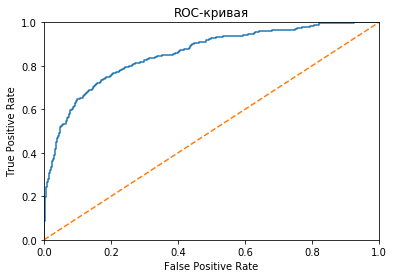

In [58]:
forest = RandomForestClassifier(
    random_state=17,
    max_depth=9,
    n_estimators=90
)

forest.fit(features_upsampled, target_upsampled)

probabilities_valid = forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

ROC кривая сильно выше горизонтальной прямой, определяющей модель случайного выбора,
поэтому итоговая получившаяся модель лучше случайной

## Тестирование модели

Протестируем лучшую модель на тестовой выборке

In [68]:
forest = RandomForestClassifier(
    random_state=17,
    max_depth=9,
    n_estimators=90
)

forest.fit(features_upsampled, target_upsampled)

probabilities_valid = forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(f1_score(target_valid, forest.predict(features_valid)))
print(roc_auc_score(target_valid, probabilities_one_valid))

0.6153846153846154
0.8593242772553118


In [69]:
probabilities_test = forest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print(f1_score(target_test, forest.predict(features_test)))
print(roc_auc_score(target_test, probabilities_one_test))

0.6081229418221733
0.8567949631741506


Тестирование показало, что модель обучена нормально

Проанализируем изменение метрик в ходе балансировки

In [70]:
d_f1 = {'F1': [0.356, 0.543, 0.552],
          'F1_up': [0.472, 0.562, 0.615],
          'F1_down': [0.482, 0.543, 0.607]
         }
d_auc = {'AUC_ROC': [0.765, 0.822, 0.833],
          'AUC_ROC_up': [0.768, 0.811, 0.859],
          'AUC_ROC_down': [0.769, 0.827, 0.851]
         }
f1 = pd.DataFrame(data=d_f1, index=['log', 'tree', 'forest']).T
auc = pd.DataFrame(data=d_auc, index=['log', 'tree', 'forest']).T
f1

,log,tree,forest
F1,0.356,0.543,0.552
F1_up,0.472,0.562,0.615
F1_down,0.482,0.543,0.607


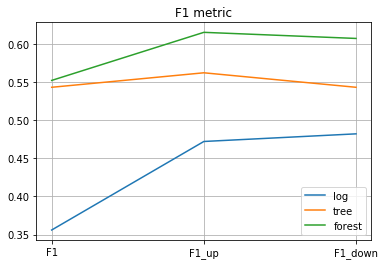

In [71]:
plt.plot(f1)
plt.title('F1 metric')
plt.legend(labels=['log', 'tree', 'forest'])
plt.grid()

Проанализируем график изменения метрики F1: <br>
<ul>
- Балансировка положительно влияет на модели логистической регрессии и случайного леса, особенно логистической регрессии.<br>
- upsampling лучше повлиял на метрики деревьев чем downsampling
</ul>

In [72]:
auc

,log,tree,forest
AUC_ROC,0.765,0.822,0.833
AUC_ROC_up,0.768,0.811,0.859
AUC_ROC_down,0.769,0.827,0.851


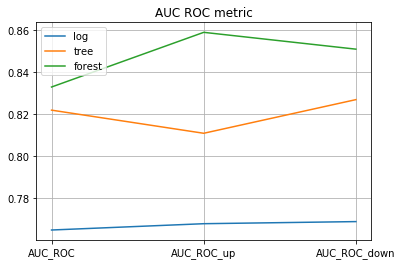

In [73]:
plt.plot(auc)
plt.title('AUC ROC metric')
plt.legend(labels=['log', 'tree', 'forest'])
plt.grid()

Проанализируем график изменения метрики AUC ROC: <br>
<ul>
- Балансировка почти не влияет на модели логистической регрессии. <br>
- Уменьшение большего класса выборки ухудшает метрику AUC ROC случайного леса.
</ul>

F1 метрика баланса между полнойтой и точностью <br>
AUC ROC - баланс между долей истинно положительных ответов (TPR) и долей ложноположительных ответов (FPR)